In [1]:
import sys
sys.path.append("..")
import os, pickle, scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
from tqdm import tqdm_notebook as tqdm
from coh_tools import *
%matplotlib inline

In [3]:
import nitime
import nitime.analysis as nta
import nitime.timeseries as ts
import nitime.utils as tsu
from nitime.viz import drawmatrix_channels

# from spectral_connectivity import Connectivity

In [4]:
# os.chdir("/mnt/hdd2tb/lab/elife/data")
os.chdir(r"C:\Users\julienb\lab\data")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\julienb\\lab\\data'

In [4]:
experiments = pd.read_csv('table_of_experiments.csv')

In [5]:
stim_experiments = experiments #.loc[experiments["stim_Coh_from"] != 0]

In [6]:
stim_experiments.head()

Experiment   Monkey  YYYYMMDD   Session PREAMP  \
0  Experiment1  MonkeyG  20150908  Session2     M1   
1  Experiment2  MonkeyG  20150908  Session3     M1   
2  Experiment3  MonkeyG  20150908  Session4     M1   
3  Experiment4  MonkeyG  20150909  Session2     M1   
4  Experiment5  MonkeyG  20150909  Session3     M1   

                          File Name  stim_Coh_from  stim_Coh_to  \
0  MonkeyG_20150908_Session2_M1.zip             46           63   
1  MonkeyG_20150908_Session3_M1.zip             48           43   
2  MonkeyG_20150908_Session4_M1.zip             48           16   
3  MonkeyG_20150909_Session2_M1.zip             48           12   
4  MonkeyG_20150909_Session3_M1.zip             53           27   

   Number of Lasers in Experiment  Number of Lasers during Conditioning Delay  \
0                               2                                     2  10ms   
1                               2                                     2  10ms   
2                               2                                     2  10ms   
3                               2                                     2  10ms   
4                               2                                     2  10ms   

                                            m1_sites  \
0  1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...   
1  1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...   
2  1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...   
3  1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,2,4...   
4  1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,2,4...   

                                            s1_sites  
0  50,52,54,56,57,58,59,60,61,62,63,64,65,66,67,6...  
1  50,52,54,56,57,58,59,60,61,62,63,64,65,66,67,6...  
2  50,52,54,56,57,58,59,60,61,62,63,64,65,66,67,6...  
3  10,33,34,35,36,37,54,56,57,58,59,60,61,62,63,6...  
4  10,33,34,35,36,37,54,56,57,58,59,60,61,62,63,6...

In [7]:
stim_experiments_list = stim_experiments["File Name"].tolist()
stim_experiments_list = [name[:-4] for name in stim_experiments_list]

# Get data

In [8]:
for experiment_i in tqdm(range(len(stim_experiments_list))): 
    session_data_dict = {}
    
    experiment = stim_experiments_list[experiment_i]
    file_location = experiment + "/RecordingBlocks/"
    first = True
    file_list = os.listdir(file_location)
    file_list.sort()
    stim_index = 1

    for filename in file_list:

        if not filename.endswith(".mat"):
            continue
        baseline_filename = file_location + filename
        savenamebase = experiment[:-3] + filename[:-4]

        data, sample_freq = extract_lfp(baseline_filename, True)
        
        break
    break

In [9]:
# Data should be in format (time, channel, channel, freq)
def remove_bad_channels(data, keyname, bc_filepath, want_bc=False):
    bad_channels = pkl.load(open(bc_filepath, "rb"))
    key_bad_channels = sorted(bad_channels[keyname])
    for bad_channel in key_bad_channels[::-1]:
        data = np.delete(data, int(bad_channel-1), 0)
    if want_bc:
        return (data, bad_channels)
    return data

In [10]:
# data = remove_bad_channels(data, experiment[:-3], r'C:\Users\julienb\lab\oe_data_analysis\pickled\bad_channels.pkl')
data = remove_bad_channels(data, experiment[:-3], "/home/julien/school/lab/opto_data_analysis/pickled/bad_channels.pkl")


## Test Conditional Granger Causality Index

In [11]:
from mvgc import *

In [12]:
G = tsdata_to_autocov(data, 10)

autocov_to_mvgc(G, [0, 1], [3, 2])

/home/julien/school/lab/opto_data_analysis/conn_metric_compare/mvgc.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x - x.mean(axis)[ind]


-1.8480816063080212

In [13]:
data.shape


(67, 21365)

In [14]:
x = [1]
y = [0]


In [15]:
n = G.shape[0]
z = np.arange(n)
z = np.delete(z, [np.hstack((x, y))])
# indices of other variables (to condition out)
xz = np.hstack((x, z))
xzy = np.hstack((xz, y))
F = 0

# full regression
ixgrid1 = np.ix_(xzy, xzy)
[AF, SIG] = autocov_to_var(G[ixgrid1])

# reduced regression
ixgrid2 = np.ix_(xz, xz)
[AF, SIGR] = autocov_to_var(G[ixgrid2])

ixgrid3 = np.ix_(x, x)

F = np.log(np.linalg.det(SIGR[ixgrid3])) - np.log(np.linalg.det(SIG[ixgrid3]))

In [16]:
z

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66])

In [17]:
AF.shape

(66, 66, 10)

In [18]:
SIG

matrix([[-1.42202949e-05, -1.29064419e-05, -1.33784791e-05, ...,
          1.86672521e-06,  2.25212202e-06, -1.35919952e-05],
        [-1.07217967e-05, -9.75038790e-06, -1.01152233e-05, ...,
          1.38897684e-06,  1.67964653e-06, -1.02276380e-05],
        [-8.26699205e-06, -7.51193349e-06, -7.79092223e-06, ...,
          1.08282359e-06,  1.30711197e-06, -7.89118939e-06],
        ...,
        [-7.15085173e-06, -6.51420910e-06, -6.76210657e-06, ...,
          9.16403038e-07,  1.10891004e-06, -6.81169951e-06],
        [-6.23631428e-06, -5.68886758e-06, -5.91113538e-06, ...,
          8.03116035e-07,  9.70165082e-07, -5.93011649e-06],
        [-7.46282279e-06, -6.77970782e-06, -7.03167369e-06, ...,
          9.72835874e-07,  1.17404147e-06, -7.12645988e-06]])

In [19]:
np.log(np.linalg.det(SIGR[ixgrid3]))

-12.853898317590836

In [20]:
np.linalg.det(SIG[ixgrid3])

-9.750387897189407e-06

In [21]:
np.log(0)

/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

In [22]:
break

SyntaxError: 'break' outside loop (<ipython-input-22-6aaf1f276005>, line 4)

# Test calculating Granger causality of data

In [23]:
# Function that takes in data matrix and returns matrix of directional Granger for 20 second partitions
def timefreq_granger(signals, sample_frequency, partition_seconds=20, want_f=False):
    partition_size = partition_seconds * sample_frequency
    num_partitions = int(signals.shape[1] // partition_size)

    num_channels = signals.shape[0]
    timefreq_mm = []
    for partition_i in range(num_partitions):
        partition = signals[:, partition_i*(int(partition_size)):(partition_i+1)*(int(partition_size))]
        
        for i in range(num_channels):
            for j in range(num_channels):
                if i != j:
                    ij.append((i, j))
                    
        time_series = ts.TimeSeries(partition, sampling_rate=sample_freq)
        G = nta.GrangerAnalyzer(time_series, order=10, ij=ij)
        Gxy = np.nan_to_num(G.causality_xy)
        freqs = G.frequencies
                
        Gxy += np.dstack([np.identity(num_channels)]*freqs.shape[0])
        
        timefreq_mm.append(Gxy)
    timefreq_mm = np.array(timefreq_mm)
    if want_f:
            return (timefreq_mm, freqs)   
    return timefreq_mm

In [24]:
tfmm = timefreq_granger(data, sample_freq)

NameError: name 'ij' is not defined

In [25]:
tfmm.shape

NameError: name 'tfmm' is not defined

In [26]:
plt.imshow(tfmm[0].mean(-1))
plt.colorbar()

NameError: name 'tfmm' is not defined

In [27]:
# if we want a window of 10ms, and sampling freq is 1000, then each step is 1ms, so we want order 10

# pdata = tsu.percent_change(data)

ij = []
for i in range(64):
    for j in range(64):
        if i != j:
            ij.append((i, j))

time_series = ts.TimeSeries(data, sampling_rate=sample_freq)
G = nta.GrangerAnalyzer(time_series, order=10, ij=ij)


In [28]:
ij = [[0, 4]]

time_series = ts.TimeSeries(data, sampling_rate=sample_freq)
G = nta.GrangerAnalyzer(time_series, order=10, ij=ij)


In [29]:
np.nan_to_num(G.causality_xy)[:, :, 5][0, 4]

0.4578436293784779

In [30]:
G.frequencies.shape[0]

513

In [31]:
freq_idx_G = np.where((G.frequencies > 4) * (G.frequencies < 7))[0]


In [32]:
freq_idx_G

array([5, 6, 7])

In [33]:
G.causality_xy

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [34]:
gxy = np.mean(G.causality_xy[:, :, freq_idx_G], -1)
gyx = np.mean(G.causality_yx[:, :, freq_idx_G], -1)
gxx = np.mean(G.simultaneous_causality[:, :, freq_idx_G], -1)

gxy = np.nan_to_num(gxy)
gyx = np.nan_to_num(gyx)
gxx = np.nan_to_num(gxx)

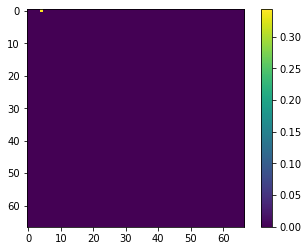

In [35]:
plt.imshow(gxy)
plt.colorbar()

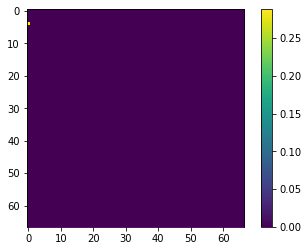

In [36]:
plt.imshow(gyx.T)
plt.colorbar()

In [37]:
np.array_equal(gyx.T, gxy)

False

In [38]:
gxy.shape

(67, 67)

## Get timefreq results for granger

In [39]:
data.shape[0]

67

In [40]:
num_channels = data.shape[0]
num_points = data.shape[1]
ij = []
for i in range(num_channels):
    for j in range(num_channels):
        if i != j:
            ij.append((i, j))
            
            
partition_size = partition_seconds * sample_frequency

time_series = ts.TimeSeries(data, sampling_rate=sample_freq)
G = nta.GrangerAnalyzer(time_series, order=10, ij=ij)

NameError: name 'partition_seconds' is not defined

In [41]:
# Function that takes in data matrix and returns matrix of coherences for 20 second partitions
# using windows of 2 seconds each, and discarding remainder of 2 seconds
def timefreq_granger(signals, sample_frequency, partition_seconds=20, want_f=False, want_phase=False):
#     num_partitions = int((signals.shape[1] / sample_frequency // partition_seconds) * 2 - 1)
    partition_size = partition_seconds * sample_frequency
    num_partitions = int(signals.shape[1] // partition_size)
    Nwin = int(partition_size // 10) # this yields number of samples for a tenth of partition seconds
    nperseg = Nwin
    nfft = nextpow2(Nwin) #16384
    ovlp = int(Nwin/2)
    timefreq_mm = []
    for partition_i in range(num_partitions):
        partition = signals[:, partition_i*(int(partition_size)):(partition_i+1)*(int(partition_size))]
        mm = np.zeros((96, 96, 1025)) # 1025 is hardcoded and should be a function
        for from_index in range(96):
            for to_index in range(from_index+1, 96):
                if want_phase:
                    c = csd(partition[from_index,:], partition[to_index,:], sample_frequency, 
                        hamming(Nwin), nperseg=nperseg, nfft=nfft, noverlap=ovlp)
                    mm[from_index, to_index] = np.angle(c[1])
                    mm[to_index, from_index] = -np.angle(c[1])
                else:
                    c = coh(partition[from_index,:], partition[to_index,:], sample_frequency, 
                        hamming(Nwin), nperseg=nperseg, nfft=nfft, noverlap=ovlp)
                    mm[from_index, to_index] = c[1]
                    mm[to_index, from_index] = c[1]
        if not want_phase:
            mm += np.dstack([np.identity(96)]*1025)
        timefreq_mm.append(mm)
    timefreq_mm = np.array(timefreq_mm)
    if want_f:
            return (timefreq_mm, c[0])   
    return timefreq_mm

# Compare to coherence

In [42]:
c = band_coherence(data, sample_freq, 4, 7)

In [43]:
c.shape

(67, 67)

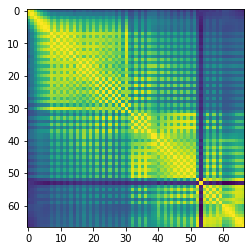

In [44]:
plt.imshow(c)

NameError: name 'sc_dc' is not defined

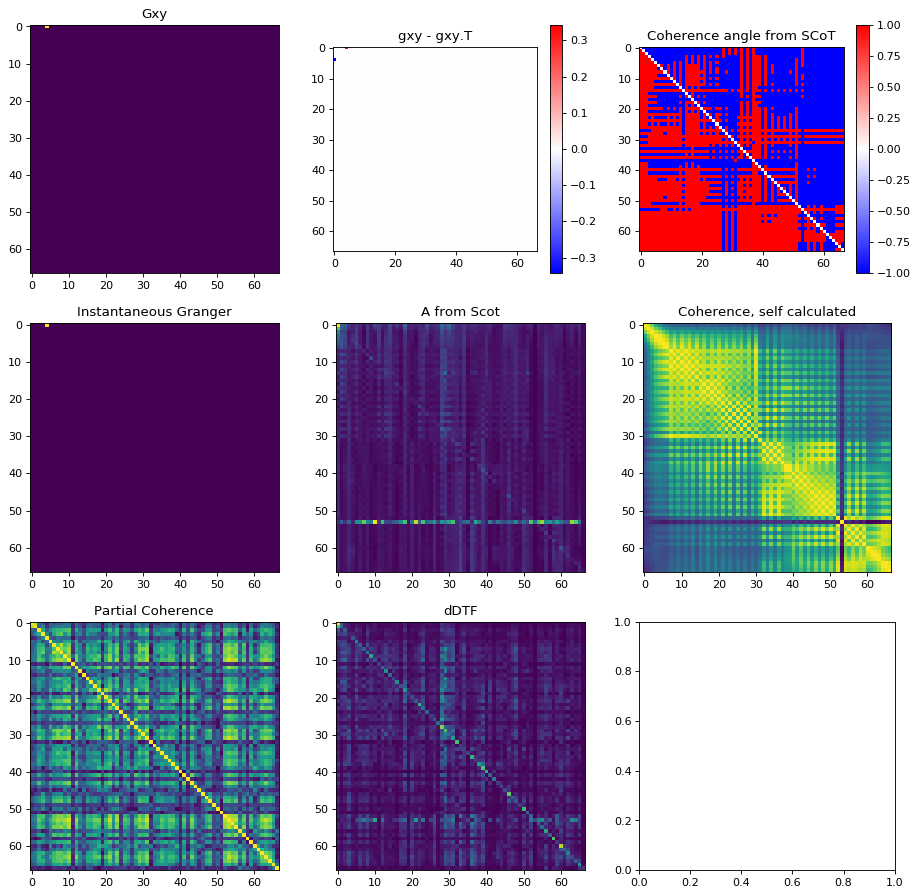

In [63]:
plt.figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')

# directional
plt.subplot(331)
plt.imshow(gxy)
plt.title("Gxy")

# directional
plt.subplot(332)
plt.imshow(gxy - gxy.T, cmap="bwr")
plt.title("gxy - gxy.T")
plt.colorbar()

plt.subplot(333)
plt.imshow(-np.sign(np.angle(con.COH()[:, :, 4:8]).mean(-1)), cmap="bwr")
plt.title("Coherence angle from SCoT")
plt.colorbar()

# instantaneous
plt.subplot(334)
plt.imshow(gxx)
plt.title("Instantaneous Granger")

plt.subplot(335)
plt.imshow(np.absolute(con.H()[:, :, 4:8]).mean(-1))
plt.title("A from Scot")

# coherence
plt.subplot(336)
plt.imshow(c)
plt.title("Coherence, self calculated")


plt.subplot(337)
plt.imshow(np.absolute(con.pCOH()[:, :, 4:8]).mean(-1))
plt.title("Partial Coherence")
# plt.colorbar()

plt.subplot(338)
plt.imshow(np.absolute(con.dDTF()[:, :, 4:8]).mean(-1))
plt.title("dDTF")

plt.subplot(339)
plt.imshow(sc_dc)
plt.title("Coh from spectral-conn.")


In [ ]:
# Okay so Im not sure why the granger results are half the matrix and not the full matrix. Need to figure that out

In [ ]:
gsm = G.spectral_matrix

In [ ]:
gsm[(0, 1)].shape

In [67]:
con.pCOH().shape

(67, 67, 512)

In [69]:
dir(con)

['A',
 'COH',
 'Cinv',
 'DTF',
 'G',
 'GDTF',
 'GPDC',
 'H',
 'PDC',
 'PDCF',
 'PHI',
 'S',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_memoize__cache',
 'absS',
 'b',
 'c',
 'dDTF',
 'ffDTF',
 'ffPDC',
 'logG',
 'logS',
 'm',
 'nfft',
 'p',
 'pCOH',
 'sPDC']

## Test SCoT implementation

In [46]:
import scot


In [47]:
var = scot.var.VAR(10).fit(data)

In [48]:
dir(con)

NameError: name 'con' is not defined

In [54]:
var.coef.shape

(67, 670)

In [55]:
con = scot.connectivity.Connectivity(var.coef, np.eye(67))

In [56]:
con.H().shape

(67, 67, 512)

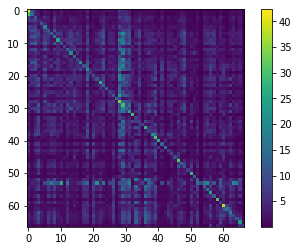

In [57]:
plt.imshow(np.absolute(con.dDTF()[:, :, 4:8]).mean(-1))
plt.colorbar()

## Test spectral_connectivity implementation

In [58]:
from spectral_connectivity import Connectivity, Multitaper

In [59]:
m = Multitaper(data.T,
                   sampling_frequency=sample_freq,
                   time_halfbandwidth_product=3,
                   start_time=0)

In [60]:
sc_c = Connectivity(fourier_coefficients=m.fft(),
                     frequencies=m.frequencies,
                     time=m.time)

In [61]:
dir(sc_c)

['_MVAR_Fourier_coefficients',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cross_spectral_matrix',
 '_expectation',
 '_frequencies',
 '_minimum_phase_factor',
 '_noise_covariance',
 '_power',
 '_transfer_function',
 'blockwise_spectral_granger_prediction',
 'canonical_coherence',
 'coherence_magnitude',
 'coherence_phase',
 'coherency',
 'conditional_spectral_granger_prediction',
 'debiased_squared_phase_lag_index',
 'debiased_squared_weighted_phase_lag_index',
 'delay',
 'direct_directed_transfer_function',
 'directed_coherence',
 'directed_transfer_function',
 'expectation_type',
 'fourier_coefficients',
 'frequencies',
 'from_multitaper',
 'generalized_partial

In [62]:
sc_coh = sc_c.coherence_magnitude()
sc_dc = sc_c.pairwise_spectral_granger_prediction()
# sc_dc = sc_c.directed_coherence()

KeyboardInterrupt: 

In [ ]:
sc_dc = np.nan_to_num(sc_dc[0, 85:149, :, :].mean(axis=0))
sc_coh = np.nan_to_num(sc_coh[0, 85:149, :, :].mean(axis=0))

In [ ]:
get_freq_band_indices(m.frequencies, 4, 7)

In [ ]:
plt.imshow(sc_dc)

In [ ]:
break

In [ ]:
for experiment_i in tqdm(range(len(stim_experiments_list))): 
    session_data_dict = {}
    
    experiment = stim_experiments_list[experiment_i]
    file_location = experiment + "/RecordingBlocks/"
    first = True
    file_list = os.listdir(file_location)
    file_list.sort()
    stim_index = 1

    for filename in file_list:

        if not filename.endswith(".mat"):
            continue
        baseline_filename = file_location + filename
        savenamebase = experiment[:-3] + filename[:-4]

        data, sample_freq = extract_lfp(baseline_filename, True)
        
        break
    break

#         all_band_coherences, freqs = timefreq_coherence(data, sample_freq, want_f=True)
#         session_data_dict[baseline_filename.split('/')[-1][0:-4]] = all_band_coherences[:,:,:,:403]
        
#         if not first:
#             stim_filename = baseline_filename.replace("Recording", "Conditioning").\
#                 replace("RecBlock"+str(stim_index+1), "CondBlock"+str(stim_index))
#             stim_data = extract_lfp(stim_filename)
#             all_stim_coh = timefreq_coherence(stim_data, sample_freq)
#             session_data_dict[stim_filename.split('/')[-1][0:-4]] = all_stim_coh[:,:,:,:403]

#             stim_index += 1

#         first = False
# #     print(freqs[0])
# #     print(freqs[-1])
# #     pkl.dump(session_data_dict, open("../pickled/test", "wb"))
# #     pkl.dump(session_data_dict,open("/media/julien/hdd2tb/lab/elife/data/pickled/20sec_allsession_coh/"+experiment, 'wb'))
# #     break
